# Gathering Data of STOCk MARKET

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your CSV data into a DataFrame
data = pd.read_csv("DataSet/currency_daily_BTC_CNY.csv")

# Get basic summary statistics
data.describe()


,open (CNY),high (CNY),low (CNY),close (CNY),open (USD),high (USD),low (USD),close (USD),volume,market cap (USD)
count,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,255610.543191,261234.879781,249699.331307,255804.325463,35284.367460,36060.748420,34468.386360,35311.117080,102735.293092,102735.293092
std,102107.249804,104848.968332,98977.479479,102355.575337,14094.840054,14473.305679,13662.807929,14129.118802,114702.858893,114702.858893
min,114324.399100,118190.754500,112112.786800,114324.399100,15781.290000,16315.000000,15476.000000,15781.290000,1077.048050,1077.048050
25%,170571.154675,175452.816750,167415.573800,170571.154675,23545.567500,24219.430000,23109.972500,23545.567500,33993.421150,33993.421150
50%,219442.343400,222716.296150,215490.251750,219442.379600,30291.725000,30743.660000,29746.180000,30291.730000,51676.750735,51676.750735
75%,317769.281650,322464.566075,309920.209375,317868.401775,43864.732500,44512.867500,42781.250000,43878.415000,126016.635200,126016.635200
max,529358.387300,534462.721100,516759.897600,529358.459800,73072.400000,73777.000000,71333.310000,73072.410000,760705.362800,760705.362800


## Analysis of numerical Data

In [2]:
# Analyze specific numerical data (replace 'column_name' with actual column name)
data['open (CNY)'].describe()

count      1000.000000
mean     255610.543191
std      102107.249804
min      114324.399100
25%      170571.154675
50%      219442.343400
75%      317769.281650
max      529358.387300
Name: open (CNY), dtype: float64

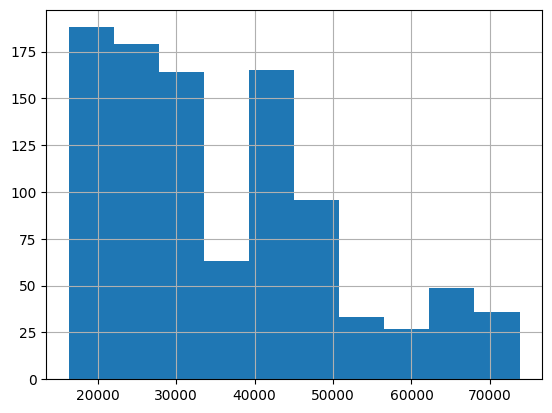

In [3]:

data['high (USD)'].hist()  # visualize distribution of a specific price column
plt.show()

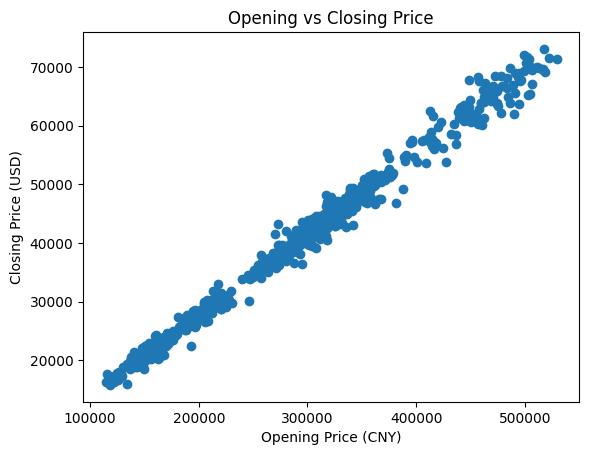

In [4]:
# Analyze relationships between numerical data (scatter plot)
plt.scatter(data["open (CNY)"], data["close (USD)"])  # Example: opening price (CNY) vs closing price (USD)
plt.xlabel("Opening Price (CNY)")
plt.ylabel("Closing Price (USD)")
plt.title("Opening vs Closing Price")
plt.show()

## Feature Selection 

In [5]:
import pandas as pd
from datetime import datetime
import numpy as np
from sklearn.preprocessing import StandardScaler

# Assuming your data is loaded into a Pandas DataFrame named 'data'

# Assuming your 'timestamp' column is in a format suitable for conversion to datetime (e.g., YYYY-MM-DD)
data['timestamp'] = pd.to_datetime(data['timestamp'])

# Define the epoch timestamp (reference point)
epoch = datetime.utcfromtimestamp(0)

# Calculate the difference between each timestamp and the epoch in days
data['days_since_epoch'] = (data['timestamp'] - epoch).dt.days

# Select relevant features (replace with your actual column names)
selected_features = ['timestamp', 'open (CNY)', 'high (CNY)', 'low (CNY)', 'close (CNY)', 'volume', 'days_since_epoch']
selected_features.append('market cap (USD)')

# Create a new DataFrame with only selected features
data_for_model = data[selected_features]

## Feature Engineering

In [6]:


# ===============================================================

# Option 1 (Recommended): Using `.assign` for clear and efficient calculations
def calculate_moving_averages(data, window_sizes):
  """Calculates multiple moving averages for a given DataFrame.

  Args:
      data (pd.DataFrame): The DataFrame containing the closing price data.
      window_sizes (list): A list of window sizes for calculating moving averages.

  Returns:
      pd.DataFrame: The DataFrame with added moving average columns.
  """

  for window_size in window_sizes:
    data['MA_' + str(window_size)] = data['close (CNY)'].rolling(window=window_size).mean()
  return data

data_for_model = data_for_model.assign(**calculate_moving_averages(data_for_model.copy(), [7, 30]))

# Option 2 (Alternative): Using `.loc` for explicit assignment
# data_for_model['MA_7'] = data_for_model['close (CNY)'].rolling(window=7).mean().loc[:, 'MA_7']
# data_for_model['MA_30'] = data_for_model['close (CNY)'].rolling(window=30).mean().loc[:, 'MA_30']

# Calculate Relative Strength Index (RSI)
def calculate_rsi(close_prices, window_size=14):
  """
  This function calculates the Relative Strength Index (RSI) for a given set of closing prices.

  Args:
      close_prices (np.array): A NumPy array of closing prices.
      window_size (int, optional): The window size for calculating the RSI. Defaults to 14.

  Returns:
      np.array: A NumPy array of RSI values for each closing price.
  """

  # Calculate the difference between consecutive closing prices (gains/losses)
  delta_prices = np.diff(close_prices)

  # Filter out the first element (no previous price for comparison)
  delta_prices = delta_prices[1:]

  # Identify positive and negative changes (gains and losses)
  up_changes = np.where(delta_prices > 0, delta_prices, 0)
  down_changes = np.abs(np.where(delta_prices < 0, delta_prices, 0))

  # Calculate the average gain and loss over the window size (use np.nanmean to handle potential NaNs)
  avg_gain = np.nanmean(up_changes[-window_size:])
  avg_loss = np.nanmean(down_changes[-window_size:])

  # Avoid division by zero (if all prices are the same)
  if avg_loss == 0:
    return np.zeros_like(close_prices)  # Return all zeros for RSI if no losses

  # Calculate the Relative Strength (RS)
  rs = avg_gain / avg_loss

  # Calculate the RSI using the formula
  rsi = 100 - (100 / (1 + rs))

  return rsi

# Use `.apply` with `raw=True` to return NumPy array directly
data_for_model['RSI'] = data_for_model['close (CNY)'].rolling(window=14).apply(calculate_rsi, raw=True)

# Calculate standard deviation of closing prices for the past week (volatility)
data_for_model['volatility'] = data_for_model['close (CNY)'].rolling(window=7).std()

# Data Cleaning and Preprocessing

# Handle missing values (replace with your chosen method)
# For example, impute missing values with the median
data_for_model.fillna(data_for_model.median(), inplace=True)

# Identify and handle outliers (optional)
# You can explore libraries like 'scipy.stats' for outlier detection


In [7]:
data_for_model

,timestamp,open (CNY),high (CNY),low (CNY),close (CNY),volume,days_since_epoch,market cap (USD),MA_7,MA_30,RSI,volatility
0,2024-04-24,481122.9402,483540.5804,480949.0770,483422.4983,1077.04805,19837,1077.04805,219234.049093,216007.398197,48.570811,5765.552523
1,2024-04-23,484059.1999,486693.8793,476427.2574,481122.9402,22599.90004,19836,22599.90004,219234.049093,216007.398197,48.570811,5765.552523
2,2024-04-22,470453.1729,487051.3131,467257.3500,484059.1999,31397.99371,19835,31397.99371,219234.049093,216007.398197,48.570811,5765.552523
3,2024-04-21,470449.0437,475918.3453,465355.7213,470453.1729,19316.42152,19834,19316.42152,219234.049093,216007.398197,48.570811,5765.552523
4,2024-04-20,462316.8098,473914.8617,457043.3941,470449.1161,23137.42975,19833,23137.42975,219234.049093,216007.398197,48.570811,5765.552523
...,...,...,...,...,...,...,...,...,...,...,...,...
995,2021-08-03,283591.5979,288178.2540,272690.1579,276783.3323,57117.43585,18842,57117.43585,306588.990457,334600.054387,22.052349,20653.822891
996,2021-08-02,288687.3110,293249.3364,280281.9670,283598.5524,50837.35195,18841,50837.35195,299235.425714,332266.737800,26.041977,17786.467882
997,2021-08-01,300362.0075,308599.9357,285584.8670,288652.3210,53953.18633,18840,53953.18633,295148.678057,330514.715920,25.890129,16167.730085
998,2021-07-31,305755.5337,307506.0464,297017.3866,300361.9351,44849.79101,18839,44849.79101,291929.404286,329181.503927,40.017686,11203.004292


In [8]:

# -------------------Scaling
scaler = StandardScaler()
scaler.fit(data_for_model.iloc[:, 1:])  # Exclude the first column (timestamp) for scaling
data_for_model.iloc[:, 1:] = scaler.transform(data_for_model.iloc[:, 1:])


C:\Users\hp\AppData\Local\Temp\ipykernel_5940\1767851019.py:4: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.73031962  1.72685552  1.72339142  1.71992731  1.71646321  1.71299911
  1.709535    1.7060709   1.7026068   1.69914269  1.69567859  1.69221449
  1.68875038  1.68528628  1.68182218  1.67835807  1.67489397  1.67142987
  1.66796576  1.66450166  1.66103755  1.65757345  1.65410935  1.65064524
  1.64718114  1.64371704  1.64025293  1.63678883  1.63332473  1.62986062
  1.62639652  1.62293242  1.61946831  1.61600421  1.61254011  1.609076
  1.6056119   1.6021478   1.59868369  1.59521959  1.59175549  1.58829138
  1.58482728  1.58136318  1.57789907  1.57443497  1.57097087  1.56750676
  1.56404266  1.56057856  1.55711445  1.55365035  1.55018625  1.54672214
  1.54325804  1.53979394  1.53632983  1.53286573  1.52940163  1.52593752
  1.52247342  1.51900932  1.51554521  1.51208111  1.50861701  1.5051529
  1.5016888   1.498

## Working on the Model LInear Regression

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score


### Splitting into Train and Test

In [10]:
# Define target variable (market cap)
target_variable = 'market cap (USD)'  # Replace with the actual column name for market cap in your data

# Split features (all columns except target) and target variable
X_train, X_test, y_train, y_test = train_test_split(data_for_model.iloc[:, 1:], data_for_model[target_variable], test_size=0.2, random_state=42)


### Create and Train the LR model

In [11]:
# Create a linear regression model object
model = LinearRegression()

# Train the model on the training data
model.fit(X_train, y_train)


LinearRegression()

### Make prediction

In [12]:
# Predict market cap values for the testing set
y_pred = model.predict(X_test)

> MSE: Lower values indicate better model performance.

> R-squared: Closer to 1 signifies a better fit between the model's predictions and the actual market cap values.

### Evaluate the model's performance:

In [13]:
# Calculate mean squared error (MSE)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

# Calculate R-squared
r2 = r2_score(y_test, y_pred)
print(f"R-squared: {r2}")


Mean Squared Error: 4.366417814253701e-31
R-squared: 1.0


In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


In [16]:
# Assuming data_for_model is your DataFrame
X_train, X_test, y_train, y_test = train_test_split(data_for_model[['open (CNY)']], data_for_model[target_variable], test_size=0.2, random_state=42)


In [17]:
model = LinearRegression()
model.fit(X_train, y_train)


LinearRegression()

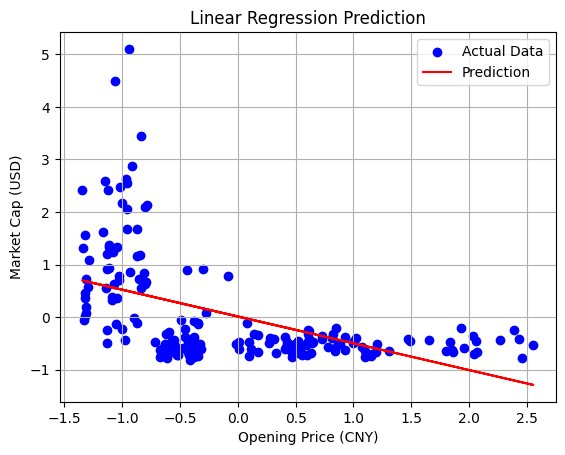

In [18]:
y_pred = model.predict(X_test)
plt.scatter(X_test['open (CNY)'], y_test, color='blue', label='Actual Data')
plt.plot(X_test['open (CNY)'], y_pred, color='red', label='Prediction')

plt.xlabel('Opening Price (CNY)')
plt.ylabel('Market Cap (USD)')
plt.title('Linear Regression Prediction')
plt.legend()
plt.grid(True)
plt.show()
